# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection

## Notebook: LightGBM Tuning

***

**What is the objective of this file?**

To tune the model using the Train Split (Dynamically Split).

# Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. LightGBM Tuning Setup

Setting tuning environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. What is the dictionary of hyperparameter values?

In [1]:
OUTPUT_FILENAME = "RYZEN_TUNE_RUN1" # <== Specify the filename of the output hyperparameters text file (can be used during tuned model training).

K = 5
DYNAMIC_SPLIT = 1/K # <== Expected validation ratio. Training ratio will be 1-(1/K). Just for when needed to view.
RANDOM_SEED = 1 # <==  <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

**Recommended Parameters as per the paper/documentation:**
1. boosting_type = gbdt
2. class_weight = balanced
3. objective* = binary
4. data_sample_strategy = goss
5. tree_learner = data

*As per documentation relative to study's objectives and needs.

In [2]:
#Sample (tested) parameter set
lgbm_params = {
    #Based-on Study (Do not change)
    'boosting_type':['gbdt'], # <== GBDT Mode, Others: 'rf' & 'dart'
    'class_weight': ['balanced'], # <== Classes are balanced/weighted equally (i.e., no inherent bias)
    'objective':['binary'], # <== Binary classification mode (same as metric:binary_logloss)
    'data_sample_strategy':['goss'], # <== Use GOSS (solution of LGBM) instead of Bagging
    
    #Common (Add and experiment with valid values)
    'max_depth':[-1,10,100,1000], # <== Range: [-1,INF} (-1 for Endless), Integer
    'learning_rate':[0.1], # <== Range: [0,1], Float, Usual values: 0.1 or 0.3
    'n_estimators':[10,50,100,500,1000], # Range: [1,INF}, Integer, Default: 100, Higher values may perform better but takes more time to train
    'reg_lambda':[0,1,2], # <== Range: Regularization rate, just search online for suggested values
    'num_leaves':[8,16,31,64,128], # <== Max number of leaves, Default: 31
    
    #Other hyperparameters
    
    #Others; Not common but can improve accuracy/performance:
    'tree_learner':['data'], #For better parallel computing (Reference: https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html)
    'device':['gpu'], # <== Remove 'gpu' if no viable GPU exists in computer; Recommended GPUs: Nvidia GTX 1000 series or higher (CUDA or OpenCL)
    'boost_from_average':['True'], # <== Adjusts initial score to the mean of labels for faster convergence
}

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries & Diagnostics

In [3]:
#Python Libraries
import time
from datetime import datetime
import os
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#Metrics (for in-tuning testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
import lightgbm
# import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

start = end = 0
LOG_FILENAME = "LGBM_Tuning_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{OUTPUT_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)
def print_to_file(label, output):
    global OUTPUT_FILENAME
    filename = OUTPUT_FILENAME + "_" + label + ".tune"
    with open("Outputs/" + filename, 'w') as f:
        f.write(str(output))
        f.close()

## 1.2. Loading Datasets

### 1.2.1. Setting Filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_LGBM.csv" # <== Location for Time-based Train Split for LightGBM
#TB_Test = "../Dataset/TB/TB_Test_LGBM.csv" # <== Location for Time-based Test Split for LightGBM
IB_Train = "../Dataset/IB/IB_LGBM.csv" # <== Location for Instance-based Train Split for LightGBM
#IB_Test = "../Dataset/IB/IB_Test_LGBM.csv" # <== Location for Instance-based Test Split for LightGBM

### 1.2.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


### 1.2.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,136,135,136,135,136,135,136,135,136,...,135,141,135,141,136,135,136,135,136,135
1,1,154,177,191,154,177,191,154,134,135,...,59,138,59,138,134,135,140,134,135,134
2,1,154,177,191,154,177,191,154,134,135,...,59,138,59,138,134,135,140,134,135,134
3,0,136,135,136,135,136,135,136,135,136,...,257,193,257,193,257,193,257,193,257,193
4,1,136,135,136,135,136,135,136,135,136,...,138,59,138,59,138,209,59,138,59,138


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148
1,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,148
2,1,154,177,191,134,135,93,153,232,56,...,148,148,148,148,148,148,148,148,148,148
3,0,136,135,183,95,262,93,153,232,236,...,148,148,148,148,148,148,148,148,148,148
4,1,136,135,183,154,177,191,134,93,153,...,148,148,148,148,148,148,148,148,148,148


## 1.3. Preparing Stratified K-Folds for RandomizedSearchCV

By default, RandomizedSearchCV uses a normal K-Folds with k value of 5.

### 1.3.1. Underlying Code for Stratified K-Folds

Most of the code is for visualizing actually. Only `getStratKFold()` matters.

In [8]:
def get_strat_kfold():
    global K
    return StratifiedKFold(n_splits=K, shuffle=True, random_state=1)

#K-folds sample visualization
def kfolds_vis(dataset):
    global K
    X = dataset.iloc[:,1:] #All rows, 2nd to last column
    y = dataset.iloc[:,0] #All rows, first column only
    fig, ax = plt.subplots(figsize=(10,K+1), dpi=300)
    train = plot_cv_indices(get_strat_kfold(), X, y, ax, K)
    plt.show()

#K-folds sample visualization (inner workings)
def plot_cv_indices(cv, X, y, ax, n_splits, lw=25):
    #From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt], indices[tr] = 1,0
        ax.scatter(range(len(indices)), [ii] * len(indices), c=indices, marker="_", 
                   lw=lw, cmap=plt.cm.Paired, vmin=0, vmax=1)
    #ax.scatter(range(len(X)), [ii] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired)
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits), yticklabels=yticklabels, xlabel="Dataset Subsample", ylabel="CV iteration", ylim=[n_splits,-1], xlim=[0, X.shape[0]])
    ax.set_title("{}".format(type(cv).__name__))
    return ax

### 1.3.2. Visualizing the K-Folds

The objective of the visualization is to show that no CV iteration will have the same set of samples (i.e., no overfitting).

Stratified K-Folds Split at 5 splits.
TB/TB_Encoded Dataset


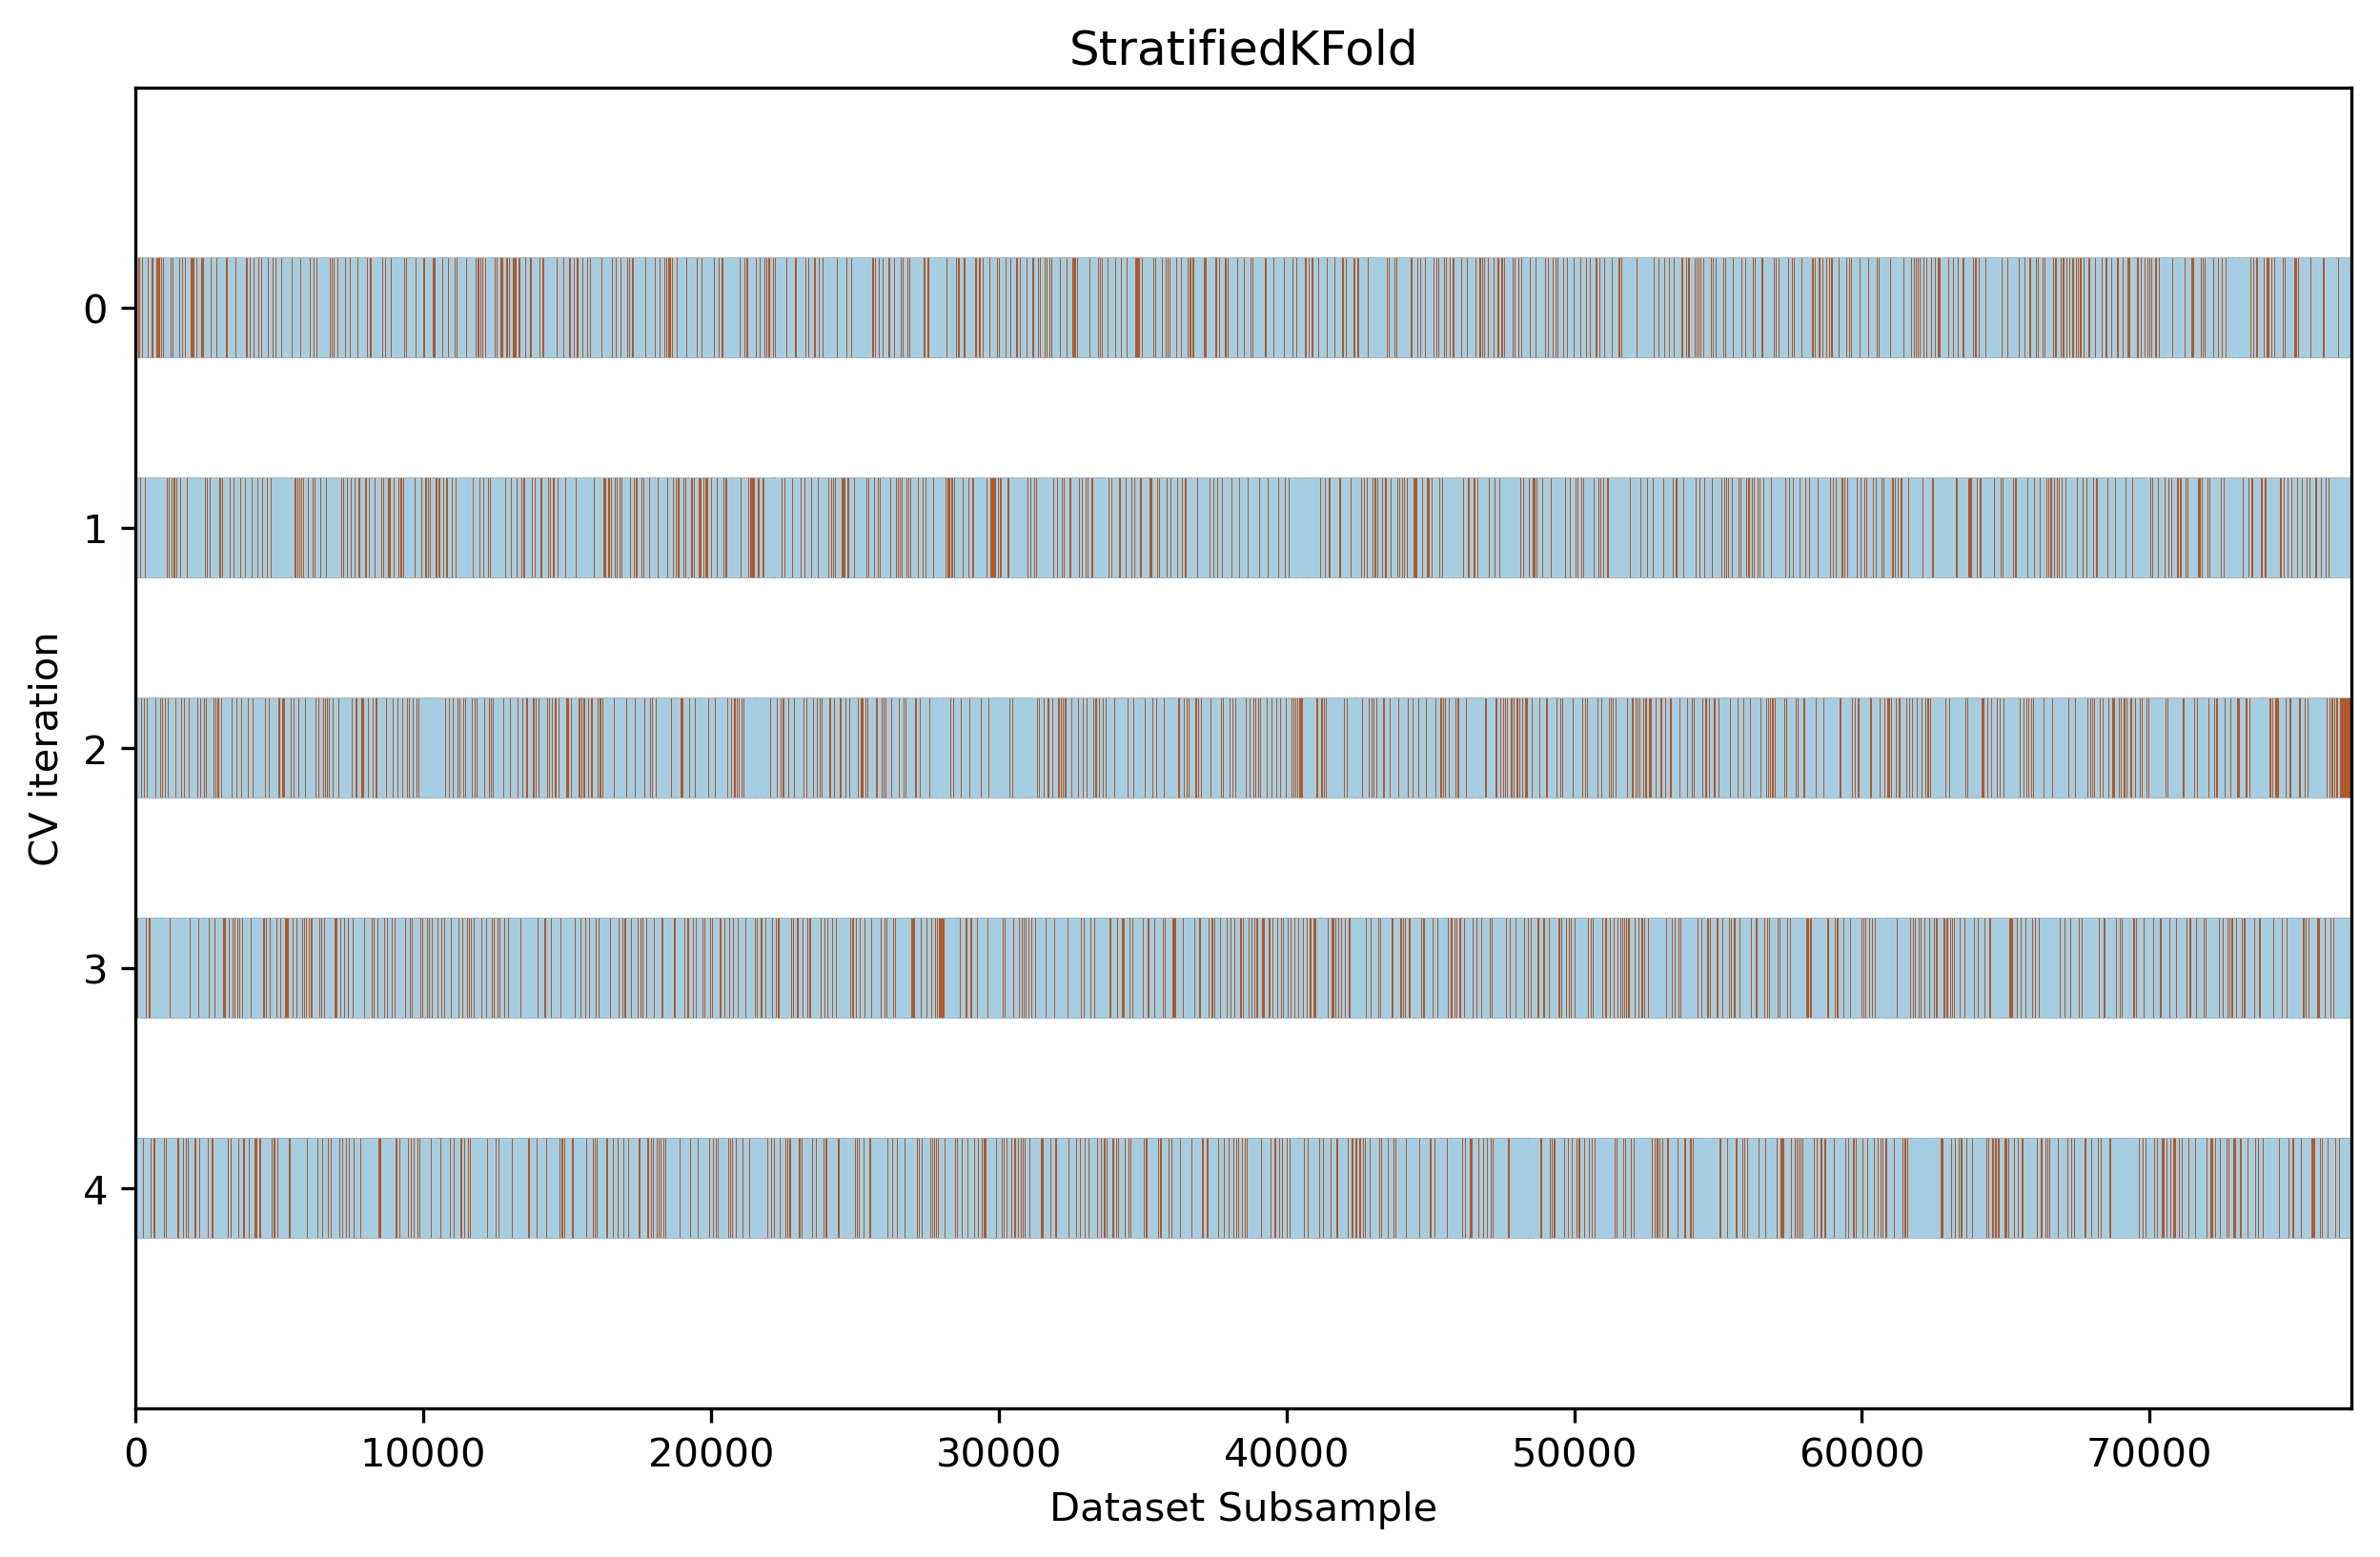

IB/IB_Encoded Dataset


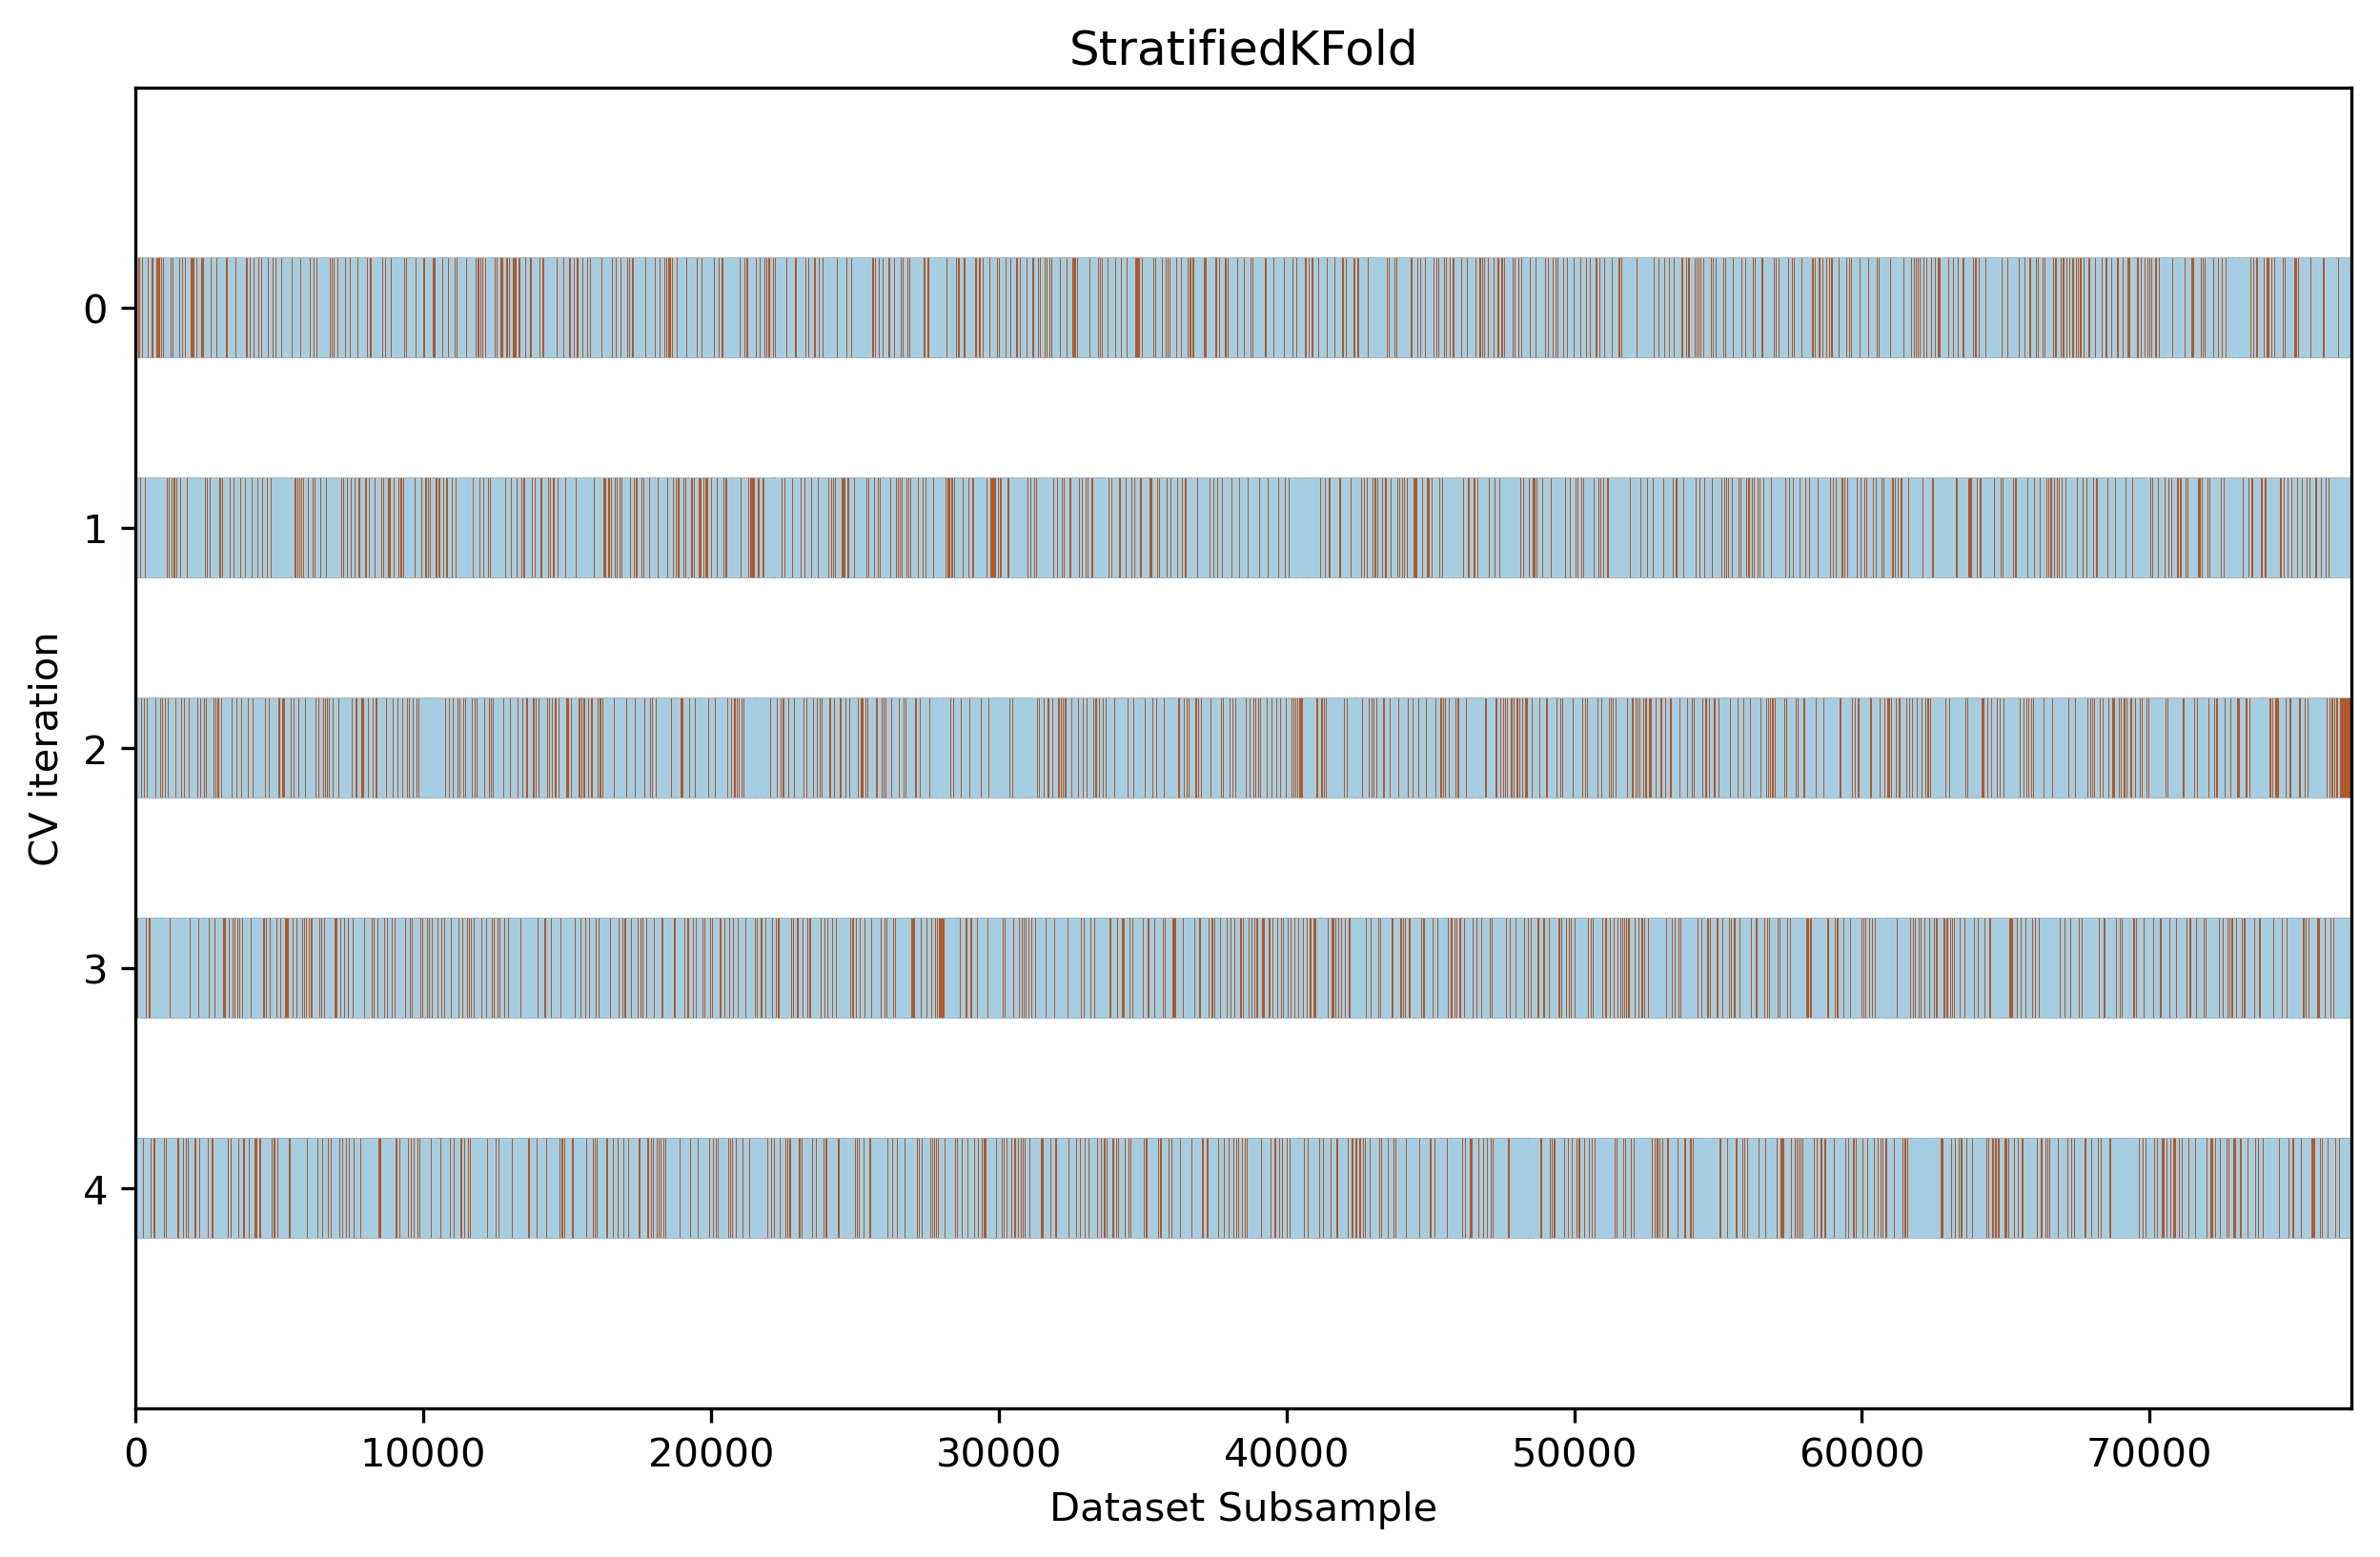

In [9]:
print("Stratified K-Folds Split at",K,"splits.")
print("TB/TB_Encoded Dataset")
kfolds_vis(tb_train)
print("IB/IB_Encoded Dataset")
kfolds_vis(ib_train)

### 1.3.3. Plotting Search CV Results

As suggested from https://stackoverflow.com/a/57013458

In [10]:
def plot_search_results(grid, cv_results, TYPE, scoring=['Accuracy','Precision','Recall','ROC-AUC']):
    ## Results from grid search
    results = grid.cv_results_
    means_test_acc = results['mean_test_accuracy']
    stds_test_acc = results['std_test_accuracy']
    means_test_prec = results['mean_test_precision']
    stds_test_prec = results['std_test_precision']
    means_test_rec = results['mean_test_recall']
    stds_test_rec = results['std_test_recall']
    means_test_auc = results['mean_test_roc_auc']
    stds_test_auc = results['std_test_roc_auc']
    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))
    params = grid.get_params()['param_grid']
    ## Ploting results
    fig, ax = plt.subplots(int(len(params)/4),4, sharex='none', sharey='none',figsize=(16,16), dpi=300)
    fig.suptitle(f'Score per parameter {str(scoring)}')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    row = col = 0
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        ax[row,col].errorbar(x, np.array(means_test_acc[best_index]), np.array(stds_test_acc[best_index]), linestyle='--', marker='o', label='Accuracy (Test)')
        ax[row,col].errorbar(x, np.array(means_test_prec[best_index]), np.array(stds_test_prec[best_index]), linestyle='--', marker='o', label='Precision (Test)')
        ax[row,col].errorbar(x, np.array(means_test_rec[best_index]), np.array(stds_test_rec[best_index]), linestyle='--', marker='o', label='Recall (Test)')
        ax[row,col].errorbar(x, np.array(means_test_auc[best_index]), np.array(stds_test_auc[best_index]), linestyle='--', marker='o', label='AUC-ROC (Test)')
        ax[row,col].set_xlabel(p.upper())
        col += 1
        if col == 4:
            col = 0
            row += 1
    plt.legend(loc='upper left')
    plt.show()
    plt.savefig('Outputs/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_HYPERPARAMS'+".png")
    plt.figure(figsize=(16,10), dpi=300)
    plt.plot(cv_results.index, cv_results['mean_test_accuracy'], linestyle='-', marker='o', label='Accuracy (Test)')
    plt.savefig('Outputs/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_ACCURACY'+".png")
    plt.plot(cv_results.index, cv_results['mean_test_precision'], linestyle='-', marker='o', label='Precision (Test)')
    plt.savefig('Outputs/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_PRECISION'+".png")
    plt.plot(cv_results.index, cv_results['mean_test_recall'], linestyle='-', marker='o', label='Recall (Test)')
    plt.savefig('Outputs/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_RECALL'+".png")
    plt.plot(cv_results.index, cv_results['mean_test_roc_auc'], linestyle='-', marker='o', label='AUC-ROC (Test)')
    plt.savefig('Outputs/'+OUTPUT_FILENAME+'_'+TYPE+'_LGBM_AUC-ROC'+".png")
    plt.ylabel('Score')
    plt.xlabel('Iterations')
    plt.title(f'{str(scoring)} per Iteration')
    plt.legend(loc='upper left')
    plt.show()

## 2. Tuning Proper

*Actual Model Tuning Process*

**Notes:**
1. Not all hyperparameters are compatible with each other.
2. Select, test, and prioritize ones that are relevant to the project.
3. The example shown below are already tested for compatibility. 
4. Watch your terminal for outputs.

LGBM Hyperparameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

CatBoost Hyperparameters: https://catboost.ai/en/docs/references/training-parameters/

## 2.1. Tuning Preparation

In [11]:
#Create the Stratified K-Folds
stratKFold = get_strat_kfold()

#Specify features (X) and labels (y) for Time-based data
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only

#Specify features (X) and labels (y) for Instance-based data
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only

def get_threshold(cv_results, target:str):
    return cv_results[target].max() - cv_results[target].std()

def refit_strategy(cv_results):
    cv_results_ = pd.DataFrame(cv_results)
    # Filter-out all results below the threshold
    high_accuracy_cv_results = cv_results_[cv_results_["mean_test_accuracy"] > .90]
    high_precision_cv_results = high_accuracy_cv_results[high_accuracy_cv_results["mean_test_precision"] > get_threshold(high_accuracy_cv_results, 'mean_test_precision')]
    high_recall_cv_results = high_precision_cv_results[high_precision_cv_results["mean_test_recall"] > get_threshold(high_precision_cv_results, 'mean_test_recall')]

    return high_recall_cv_results["mean_score_time"].idxmin() #Return the one that is fastest

def get_tuner(model, params, scoring=['accuracy','precision','recall', 'roc_auc']):
    return GridSearchCV(model, params, scoring=scoring, n_jobs=1, refit=refit_strategy, cv=get_strat_kfold(), verbose=2, pre_dispatch='2*n_jobs', error_score=0, return_train_score=False)

## 2.2. Time-based Model Tuning

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, nu

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=   1.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   1.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total time=   4.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total time=   4.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total time=   4.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; total time=  23.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  20.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  19.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total 

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; total time=   6.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; total time=   6.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=   9.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data; total time=  21.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data; total time=  21.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data; total time=  26.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data;

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=   0.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; total time=   0.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; total time=   0.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=100, num_leaves=8, objective=binary, tree_learner=data; 

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time=  11.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time=  11.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time=  11.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data;

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; total time=  34.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; total time=  35.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=data; total time=  36.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=d

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=128, objective=binary, tree_learner=data; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=128, objective=binary, tree_learner=data; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=128, objective=binary, tree_learner=data; total time=   1.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=128, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=8, objective=binary, tree_learner=data; total time=   2.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total time=   3.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total ti

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31, objective=binary, tree_learner=data; total time=  17.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31, objective=binary, tree_learner=data; total time=  17.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31, objective=binary, tree_learner=data; total time=  17.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=64, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data; total time=  41.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data; total time=  32.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data; total time=  44.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data;

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=data; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=data; total time=   2.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=  

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, objective=binary, tree_learner=data; total time=   4.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, objective=binary, tree_learner=data; total time=   4.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, objective=binary, tree_learner=data; total time=   4.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=31, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=data; total time=  22.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; total time=  27.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; total time=  27.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; tota

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   1.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total time=   5.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total time=   5.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; total time=   8.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  27.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  27.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  28.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=100, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=   1.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=   1.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   3.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   3.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; to

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=  13.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=  13.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=  13.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data; total time=  30.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data; total time=  35.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; total time=  40.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=d

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; total time=   2.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=64, objective=binary, tree_learner=data; total time=

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total time=   5.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=8, objective=binary, tree_learner=data; total time=   4.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=8, objective=binary, tree_learner=data; total time=   4.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=100, num_leaves=8, objective=binary, tree_learner=data; total time

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time=  17.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time=  17.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time=  17.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=31, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=data; total time=  51.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=data; total time=  46.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=data; total time=  45.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=1, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=64, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=128, objective=binary, tree_learner=data; total time=   3.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=128, objective=binary, tree_learner=data; total time=   3.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=data; total time=   4.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=50, num_leaves=8, objective=binary, tree_learner=data; total time=

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total time=   5.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total time=   6.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total time=   5.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=100, num_leaves=16, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=31, objective=binary, tree_learner=data; total time=  22.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=data; total time=  26.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=data; total time=  24.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=500, num_leaves=64, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data; total time=  51.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data; total time=  50.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=10, n_estimators=1000, num_leaves=128, objective=binary, tree_learner=data; total time=  46.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; to

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=   5.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=   4.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total time=   5.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=50, num_leaves=16, objective=binary, tree_learner=data; total t

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=31, objective=binary, tree_learner=data; total time=   6.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=31, objective=binary, tree_learner=data; total time=   6.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; total time=   7.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=100, num_leaves=64, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; total time=  30.7s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; total time=  26.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data; total time=  31.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=100, n_estimators=500, num_leaves=128, objective=binary, tree_learner=data;

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; total time=   2.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=10, num_leaves=16, objective=binary, tree_learner=data; tota

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   4.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   4.4s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=31, objective=binary, tree_learner=data; total time=   4.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; tot

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; total time=  10.0s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; total time=   9.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=100, num_leaves=128, objective=binary, tree_learner=data; total time=   9.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=100, num_leaves=128, objective=binary, tree_learner=d

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  37.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=8, objective=binary, tree_learner=data; total time=  35.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=data; total time=  41.5s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=1000, n_estimators=1000, num_leaves=16, objective=binary, tree_learner=dat

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=   2.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=10, num_leaves=31, objective=binary, tree_learner=data; total time=

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=64, objective=binary, tree_learner=data; total time=   5.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total time=   6.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total time=   6.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=50, num_leaves=128, objective=binary, tree_learner=data; total ti

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=  18.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=  18.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=8, objective=binary, tree_learner=data; total time=  18.6s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=500, num_leaves=16, objective=binary, tree_learner=data; total time

[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; total time=  50.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; total time=  49.8s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; total time=  51.2s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=2, learning_rate=0.1, max_depth=-1, n_estimators=1000, num_leaves=31, objective=binary, tree_learner=data; tot

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boost_from_average,param_boosting_type,param_class_weight,param_data_sample_strategy,param_device,param_l2_leaf_reg,...,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.831537,0.074413,0.061177,0.004785,True,gbdt,balanced,goss,gpu,0,...,0.000447,289,0.991581,0.992437,0.992691,0.995084,0.992732,0.992905,0.001166,289
1,0.760738,0.020810,0.056644,0.005632,True,gbdt,balanced,goss,gpu,0,...,0.000809,277,0.995220,0.996469,0.995870,0.996218,0.996610,0.996077,0.000497,277
2,0.858307,0.006682,0.059994,0.003780,True,gbdt,balanced,goss,gpu,0,...,0.000856,265,0.996434,0.997295,0.996968,0.996669,0.997184,0.996910,0.000320,273
3,0.907563,0.021808,0.059404,0.002758,True,gbdt,balanced,goss,gpu,0,...,0.000662,260,0.997300,0.998322,0.998298,0.998063,0.997814,0.997960,0.000378,262
4,1.097412,0.055717,0.062600,0.006165,True,gbdt,balanced,goss,gpu,0,...,0.000510,250,0.997788,0.998539,0.997951,0.998075,0.998062,0.998083,0.000250,251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,37.430058,0.499298,0.621879,0.006252,True,gbdt,balanced,goss,gpu,2,...,0.000536,143,0.999459,0.999475,0.999407,0.999542,0.999407,0.999458,0.000050,173
296,43.028482,0.424266,0.825005,0.057115,True,gbdt,balanced,goss,gpu,2,...,0.000445,32,0.999379,0.999497,0.999349,0.999601,0.999433,0.999452,0.000090,181
297,49.314802,1.623205,0.940922,0.022732,True,gbdt,balanced,goss,gpu,2,...,0.000510,68,0.999338,0.999596,0.999397,0.999637,0.999575,0.999509,0.000118,122
298,50.449082,4.395232,0.978128,0.045925,True,gbdt,balanced,goss,gpu,2,...,0.000394,117,0.999463,0.999628,0.999482,0.999621,0.999542,0.999547,0.000068,57


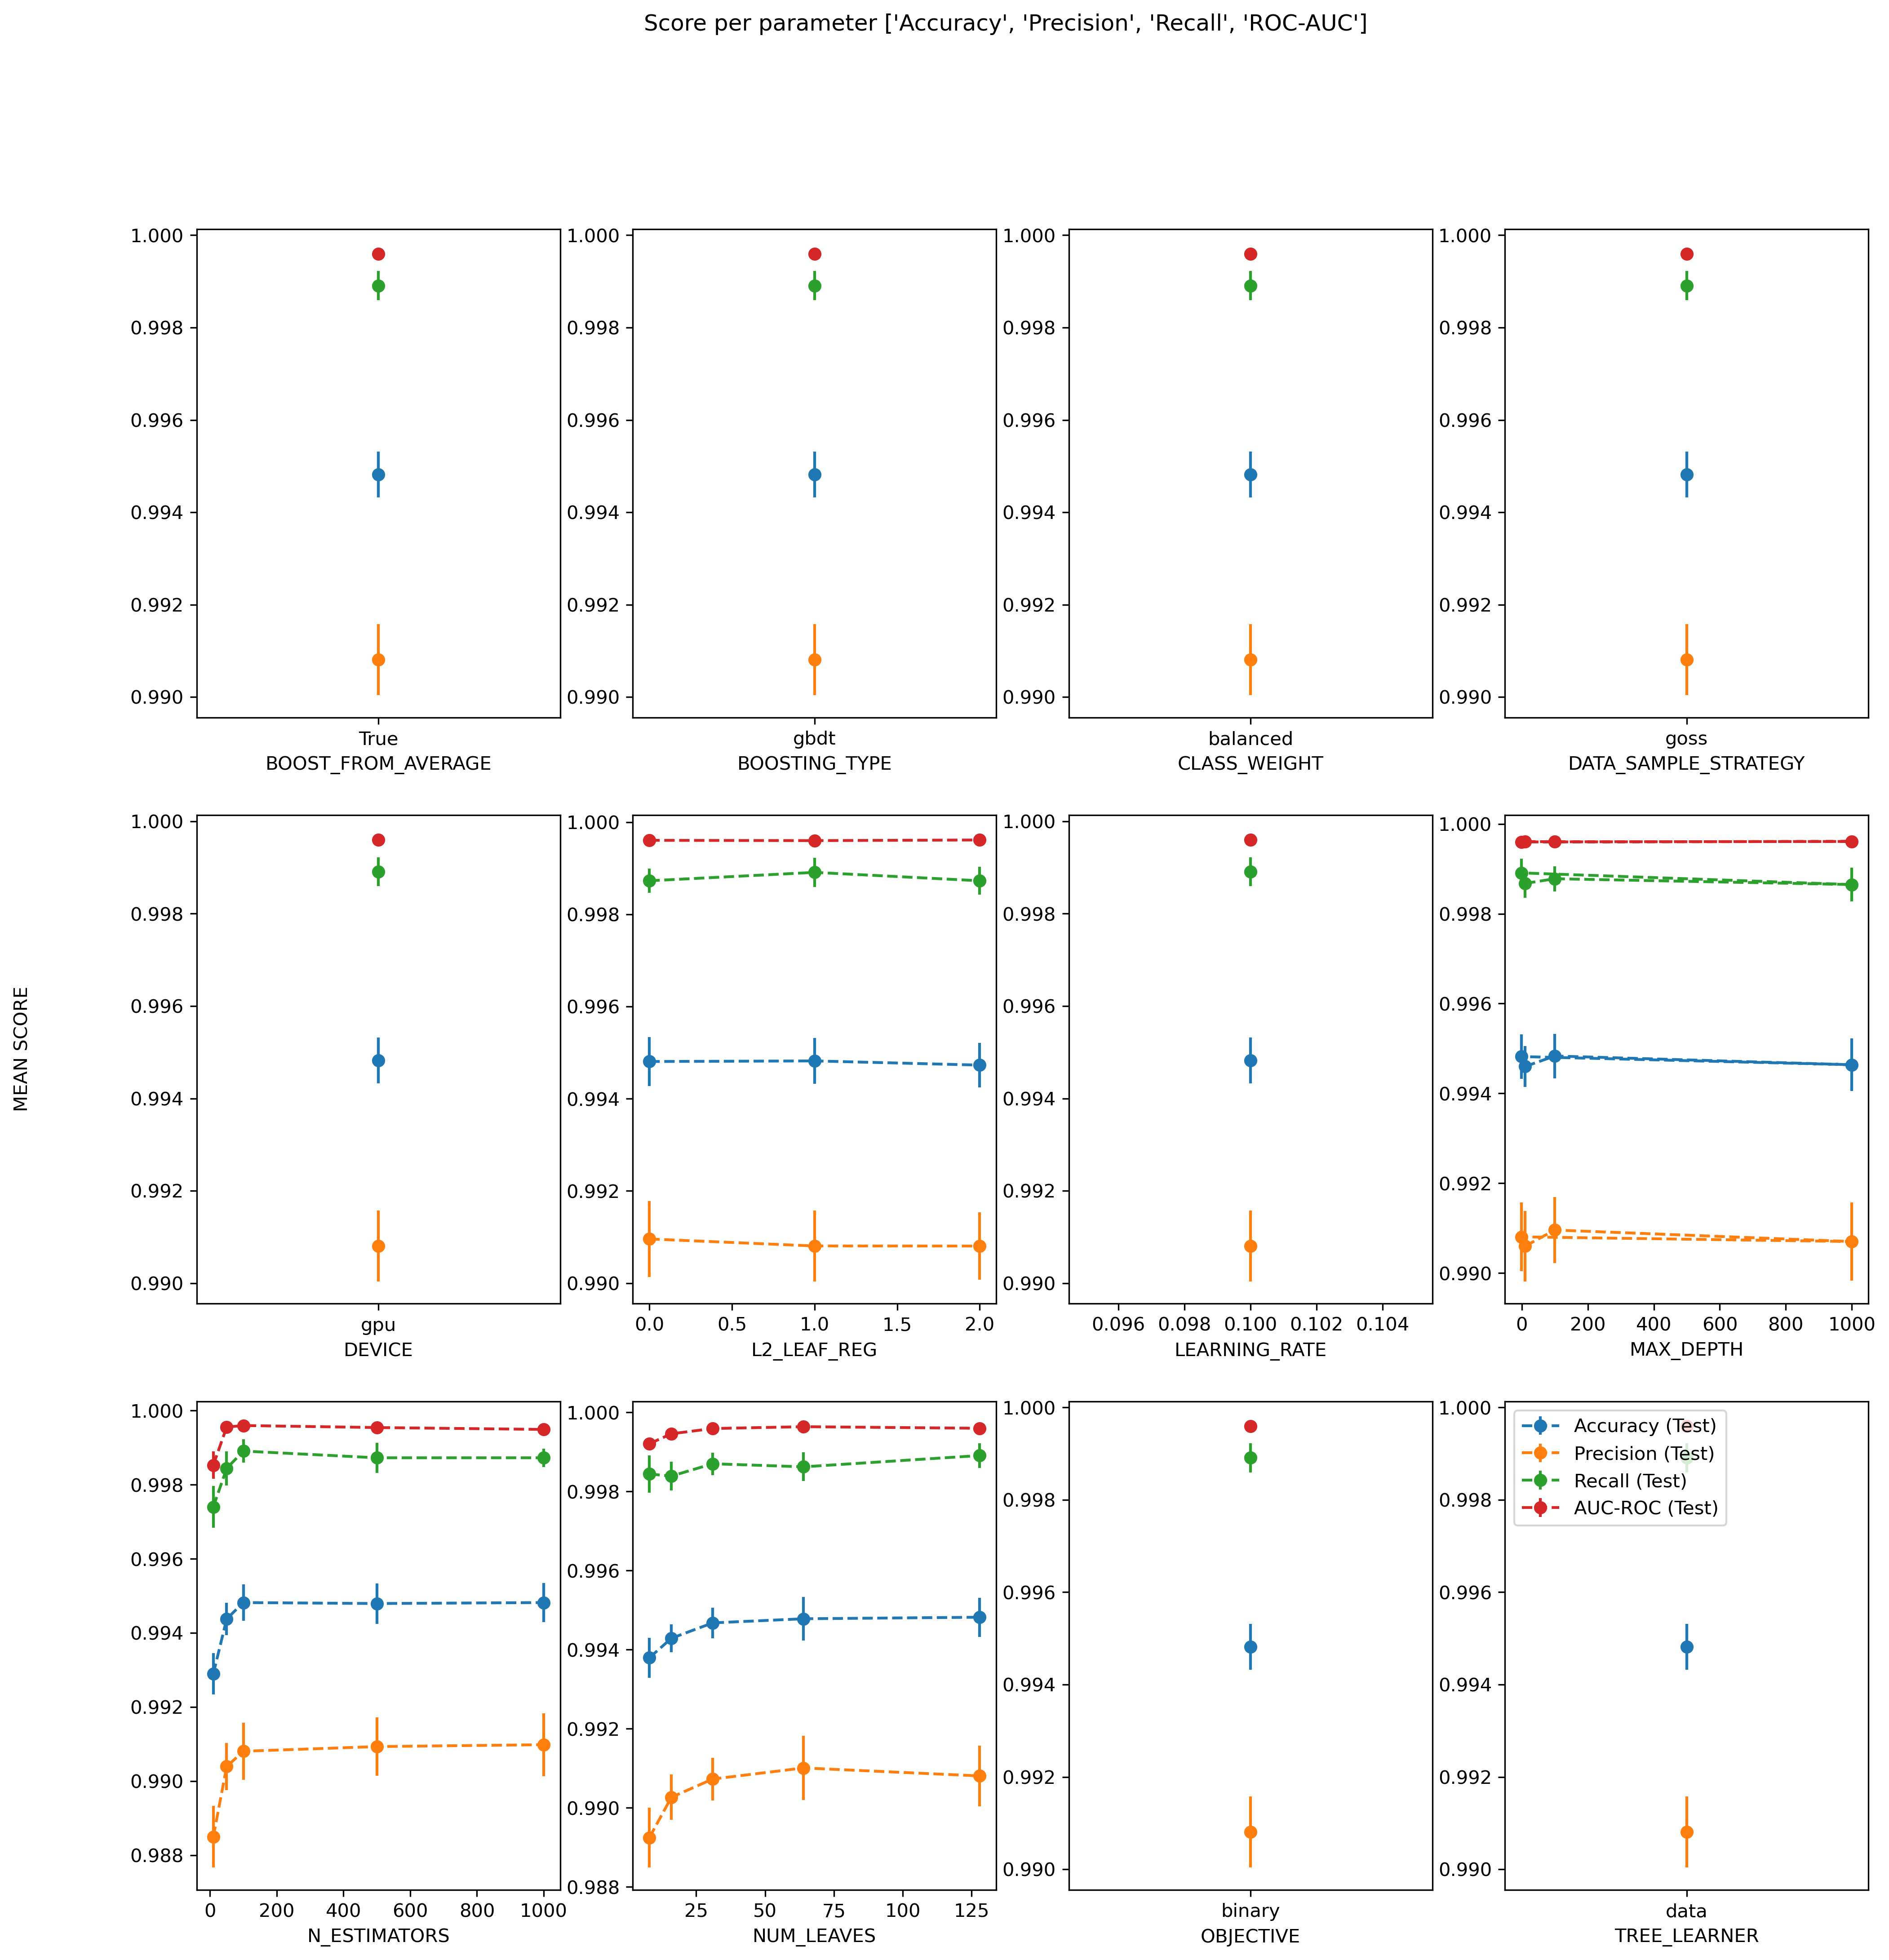

<Figure size 640x480 with 0 Axes>

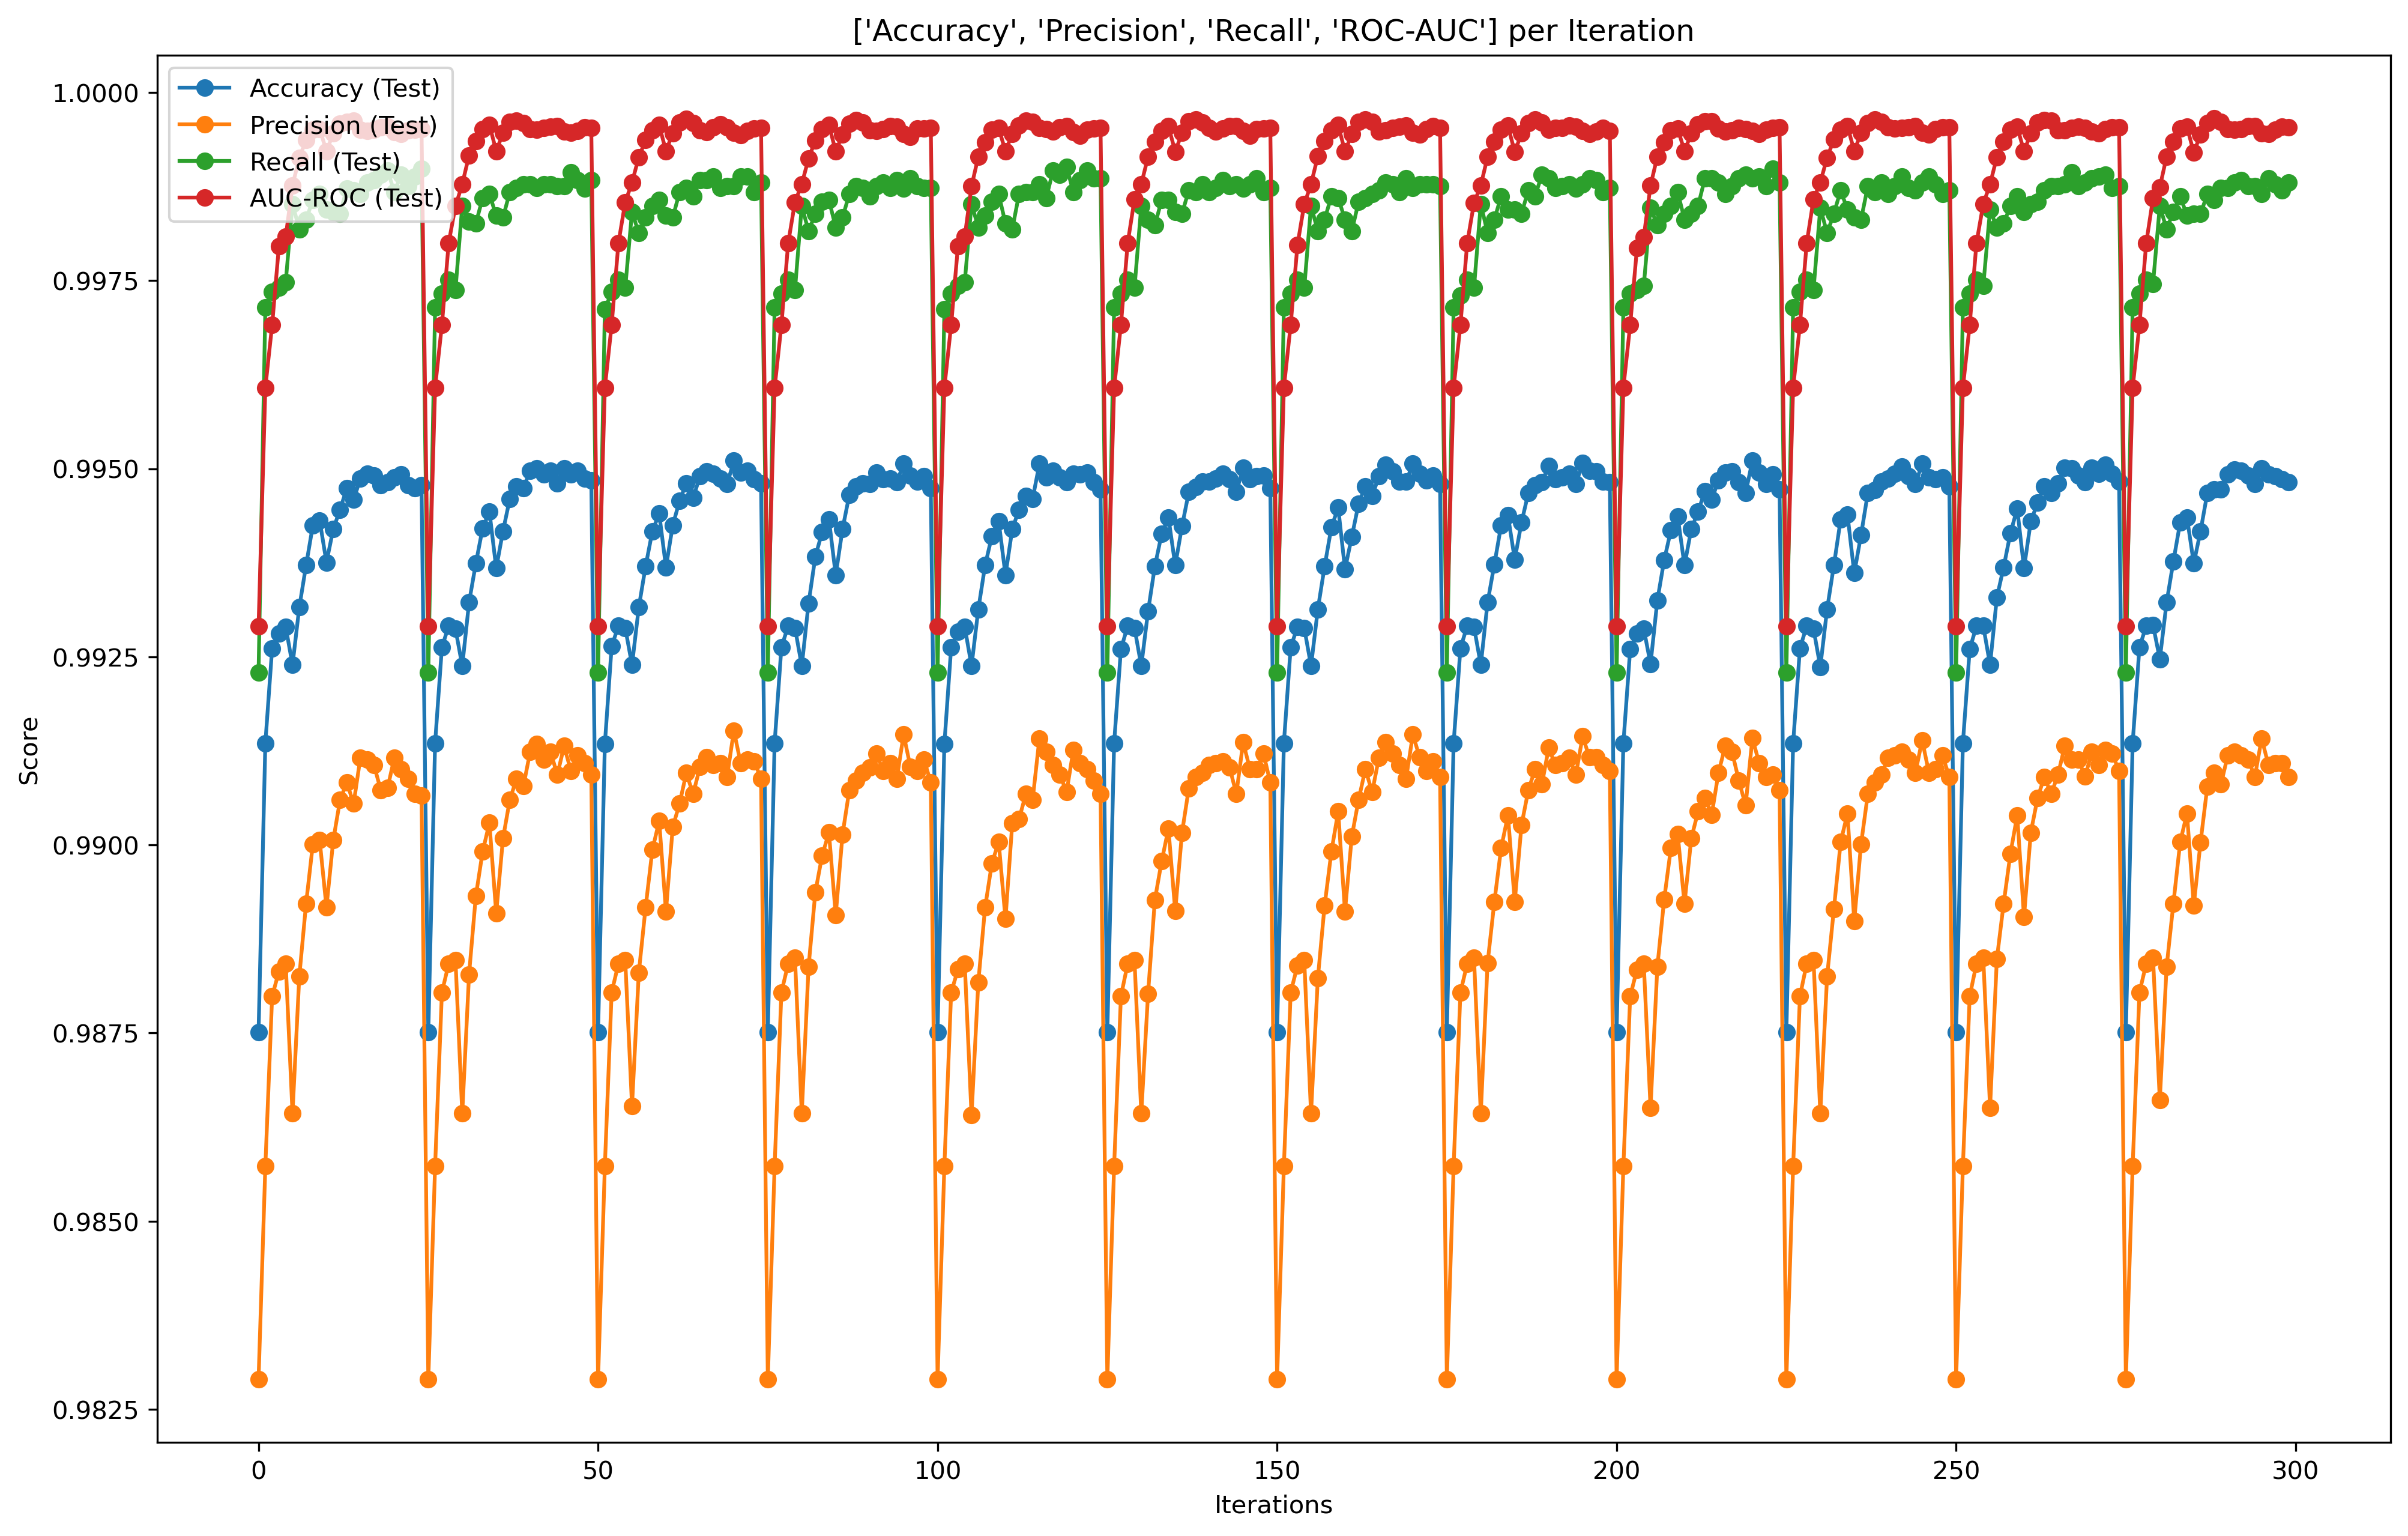

In [12]:
start_time()
lgbm_classifier = lightgbm.LGBMClassifier(random_state=1, n_jobs=int(os.cpu_count()), verbose=-1)
tb_tuner = get_tuner(lgbm_classifier, lgbm_params)
tb_tuner.fit(X_tb, y_tb)
end_time("TB_LGBM")

print_to_file("TB_LGBM", tb_tuner.best_params_)
cv_results = pd.DataFrame.from_dict(tb_tuner.cv_results_)
cv_results.to_csv('LGBM_TB_Tuning_CV_Results.csv')
display(cv_results)
plot_search_results(tb_tuner, cv_results, 'TB')

## 2.3. Instance-based Model Tuning

In [13]:
start_time()
lgbm_classifier = lightgbm.LGBMClassifier(random_state=1, n_jobs=int(os.cpu_count()), verbose=-1)
ib_tuner = get_tuner(lgbm_classifier, lgbm_params)
ib_tuner.fit(X_ib, y_ib)
end_time("IB_LGBM")

print_to_file("IB_LGBM", tb_tuner.best_params_)
cv_results = pd.DataFrame.from_dict(tb_tuner.cv_results_)
cv_results.to_csv('LGBM_IB_Tuning_CV_Results.csv')
display(cv_results)
plot_search_results(tb_tuner, cv_results, 'IB')

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   2.9s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   3.3s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=8, objective=binary, tree_learner=data; total time=   3.1s
[CV] END boost_from_average=True, boosting_type=gbdt, class_weight=balanced, data_sample_strategy=goss, device=gpu, l2_leaf_reg=0, learning_rate=0.1, max_depth=10, n_estimators=10, nu

KeyboardInterrupt: 

In [ ]:
logging("\n")